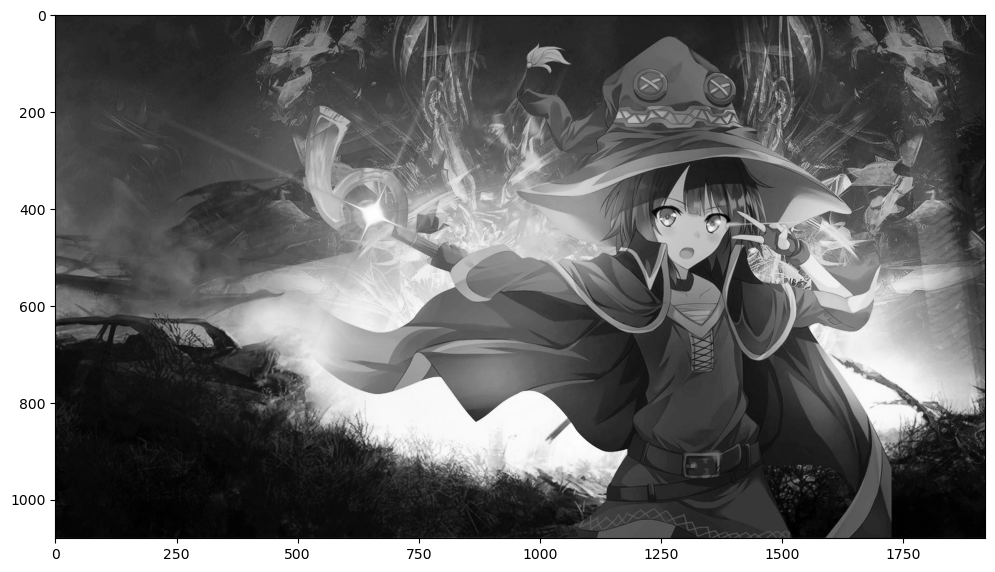

Batches per Epoch: 126.56243896484375
torch.Size([2073600, 2])
torch.Size([2073600])


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset 
from torch.utils.data.dataloader import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import model
from tqdm import tqdm

img = Image.open('images\\megumin_explosion.jpg').convert('L')
pixels = img.getdata()

width, height = img.size

x_coords = []
y_coords = []
intensity = []
for i in range(height):
    for j in range(width):
        x_coords.append(j)
        y_coords.append(height-i)
        intensity.append(pixels[i*width + j])

df = pd.DataFrame({'x': np.array(x_coords)/width, 'y': np.array(y_coords)/height, 'z': np.array(intensity)/255.})

x = np.array(x_coords).reshape((height, width))
y = np.array(y_coords).reshape((height, width))
z = np.array(intensity).reshape((height, width))

plt.figure(figsize=(12,8))
plt.imshow(img, cmap='Greys_r')
plt.show()
# plt.imshow(z, cmap='Greys_r')
# plt.show()

x_tensor = torch.tensor(df.iloc[:,0:2].values, dtype=torch.float)
y_tensor = torch.tensor(df.iloc[:,-1].values, dtype=torch.float)

# Create an instance of the dataset and dataloader
batch_size = 1024*16
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print('Batches per Epoch:', df.index[-1]/batch_size)

print(x_tensor.shape)
print(y_tensor.shape)

scale = 4
xlin = np.linspace(0, 1, width // scale)
ylin = np.linspace(0, 1, height // scale)
xv, yv = np.meshgrid(xlin, ylin)

xv_tensor = torch.tensor(xv, dtype=torch.float).flatten()
yv_tensor = torch.tensor(yv, dtype=torch.float).flatten()

reduced_tensor = torch.stack((xv_tensor, yv_tensor), dim=-1)

In [2]:
# # Define the neural network architecture
# class Net(nn.Module):
#     def __init__(self, nn_shape=(2, 4, 100, 1)):
#         super(Net, self).__init__()
#         self.num_inputs = nn_shape[0]
#         self.num_layers = nn_shape[1]
#         self.num_neurons = nn_shape[2]
#         self.num_outputs = nn_shape[3]
#         self.layers = nn.ModuleList() # create an empty list to store layers
#         self.layers.append(nn.Linear(self.num_inputs, self.num_neurons)) # add the first layer
        
#         for i in range(self.num_layers - 2): # add the remaining layers
#             self.layers.append(nn.Linear(self.num_neurons, self.num_neurons))
        
#         self.layers.append(nn.Linear(self.num_neurons, self.num_outputs)) # add the output layer
    
#     def forward(self, x):
#         for layer in self.layers[:-1]:
#             x = F.relu(layer(x))
#         x = self.layers[-1](x)
#         x = torch.sigmoid(x)
#         return x
    
# class AttentionNet(nn.Module):
#     def __init__
    
# class NeuralNetNet(nn.Module):
#     def __init__(self, nn_shape=(2,4,100,1), sub_net_shape=(3,100)):
#         self.num_inputs = nn_shape[0]
#         self.num_layers = nn_shape[1]
#         self.num_neurons = nn_shape[2]
#         self.num_outputs = nn_shape[3]
#         self.subnet_layers = sub_net_shape[0]
#         self.subnet_neurons = sub_net_shape[1]

#         self.sub_nets = nn.ModuleList() # create an empty list to store subnets
#         self.sub_nets.append(Net(nn_shape=(self.num_inputs, self.subnet_layers, self.subnet_neurons, self.num_inputs*self.num_neurons)))
#         for i in range(self.num_layers - 2): # add the remaining layers
#             self.sub_nets.append(Net(nn_shape=(self.num_inputs, self.subnet_layers, self.subnet_neurons, self.num_neurons*self.num_neurons)))
#             self.layers.append(nn.Linear(self.num_neurons, self.num_neurons))



def make_reduced_dataloader(scale=4):
    xlin = np.linspace(0, 1, width // scale)
    ylin = np.linspace(0, 1, height // scale)
    xv, yv = np.meshgrid(xlin, ylin)

    xv_tensor = torch.tensor(xv, dtype=torch.float).flatten()
    yv_tensor = torch.tensor(yv, dtype=torch.float).flatten()

    reduced_tensor = torch.stack((xv_tensor, yv_tensor), dim=-1)
    reduced_dataset = TensorDataset(reduced_tensor, torch.zeros(size=reduced_tensor.size()))
    reduced_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return reduced_dataloader

# reduced_dataloader = make_reduced_dataloader(scale=4)

# Plot Raw Network Initialization
print('Plotting Raw Network Initialization')
def plot_performance(net, scale = 4):
    reduced_dataloader = make_reduced_dataloader(scale=scale)
    with torch.no_grad():
        output_list = []
        for x_batch, y_batch in reduced_dataloader:
            outputs = net(x_batch)
            output_list.append(outputs)
        outputs = torch.cat(output_list, dim=0)

    outputs = outputs.numpy()
    output_grid = outputs.reshape((height//scale, width//scale))
    plt.figure(figsize=(12,8))
    plt.imshow(output_grid, cmap='Greys_r', origin='lower')
    plt.show()



# Create an instance of the neural network
# net = Net(nn_shape=(2,6,400,1))
# net = Net(nn_shape=(2,3,100,1))
# net = model.Net_With_Sigmoid(nn_shape=(2,6,100,1))
net = model.ResNet_With_Sigmoid(nn_shape=(2,20,200,1))

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Plot Raw Network Initialization
# plot_performance(net)
with torch.no_grad():
    outputs = net(reduced_tensor)
outputs = outputs.numpy()
output_grid = outputs.reshape((height//scale, width//scale))
plt.figure(figsize=(12,8))
plt.imshow(output_grid, cmap='Greys_r', origin='lower')
plt.show()

# Train the network for 1000 epochs
loss_values = []
n_epochs = 20
for epoch in range(n_epochs):
    for g in optimizer.param_groups:
        # g['lr'] = (0.001/n_epochs)*(n_epochs - epoch) + 0.00001
        g['lr'] = 10**(-2. - 3.*(epoch/(n_epochs-1)))
    print('Epoch', epoch, 'of', n_epochs)
    loop = tqdm(dataloader, leave=True)
    for x_batch, y_batch in loop:
        # Forward pass
        outputs = net(x_batch)
        loss = criterion(outputs, y_batch.unsqueeze(dim=-1))
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss value
        loss_values.append(loss.item())

    # Print the loss
    print(f"Loss = {loss_values[-1]}")
    # Show current network progress
    plot_performance(net)
    # if epoch in [0,1,2,4,10,20,40]:
    #     with torch.no_grad():
    #         outputs = net(reduced_tensor)
    #     outputs = outputs.numpy()
    #     output_grid = outputs.reshape((height//2, width//2))
    #     plt.figure(figsize=(12,8))
    #     plt.imshow(output_grid, cmap='Greys_r', origin='lower')
    #     plt.show()

# Save the trained model
torch.save(net.state_dict(), 'model.pt')



# Plot the loss values
epochs_values = np.array(range(len(loss_values))) / np.ceil(df.index[-1]/batch_size)
plt.plot(epochs_values, loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.show()


Plotting Raw Network Initialization


1920 1080
Loss = 0.013494647108018398


c:\Users\profe\.conda\envs\diffusion_env2\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


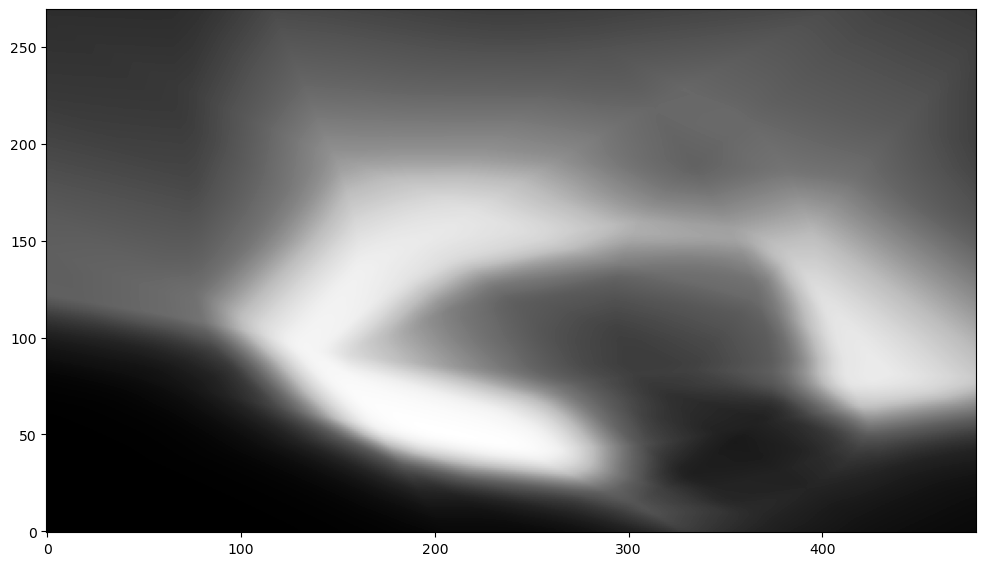

In [ ]:
print(width, height)
xlin = np.linspace(0, 1, width // scale)
ylin = np.linspace(0, 1, height // scale)
xv, yv = np.meshgrid(xlin, ylin)

xv_tensor = torch.tensor(xv, dtype=torch.float).flatten()
yv_tensor = torch.tensor(yv, dtype=torch.float).flatten()

reduced_tensor = torch.stack((xv_tensor, yv_tensor), dim=-1)

# Print the loss
print(f"Loss = {loss_values[-1]}")

# with torch.no_grad():
#     outputs = net(x_tensor)
# outputs = outputs.numpy()
# output_grid = outputs.reshape((height, width))
# plt.figure(figsize=(12,8))
# plt.imshow(output_grid, cmap='Greys_r')

with torch.no_grad():
    outputs = net(reduced_tensor)
outputs = outputs.numpy()
output_grid = outputs.reshape((height//scale, width//scale))
plt.figure(figsize=(12,8))
plt.imshow(output_grid, cmap='Greys_r', origin='lower')

In [ ]:
print(net)

Net(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): Linear(in_features=400, out_features=400, bias=True)
    (4): Linear(in_features=400, out_features=400, bias=True)
    (5): Linear(in_features=400, out_features=1, bias=True)
  )
)


In [ ]:
len(z)

-2.0
-5.0


0.01